In [1]:
import keras
import SimpleITK
import numpy as np
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

inputs_path = "../inputs"
luna_path = inputs_path + "/CSVFILES/"
luna_subset_path = inputs_path + "/subset*/"

df_node = pd.read_csv(luna_path + "annotations.csv")

resampled_file_list = glob("../preprocess/*.npz")

input_dim = 48

Using CNTK backend


## Load model

In [2]:
model_path = "../notebooks/base_2017-07-05-10-04-34-val_loss_checkpoint.hdf5"
model = keras.models.load_model(model_path)

### Define helper functions for getting 3D cubes

In [3]:
import os, math

def get_seriesuid(filepath):
    basename = os.path.basename(filepath)
    
    return basename[:-8]

def switch_xz(arr):
    return np.array([arr[2], arr[1], arr[0]])

def get_nodule_index(nodule_info, new_spacing, origin_zyx):
    nodule_coordinates = np.array(nodule_info[1:4]).astype(np.float32) # x,y,z

    nodule_index = np.rint((switch_xz(nodule_coordinates) - origin_zyx) / new_spacing).astype(np.int16)  # z,y,x
    
    return nodule_index

def get_range(x, minx, maxx, dim):
    hdim = int(dim / 2)

    if x - hdim <= minx:
        xs = minx
        xe = xs + dim
    elif x + hdim >= maxx:
        xe = maxx
        xs = xe - dim
    else:
        xs = x - hdim
        xe = xs + dim
    
    return xs, xe

def get_3D_cube(img_array, x, y, z, dim):
    xr = get_range(x, 0, img_array.shape[2], dim)
    yr = get_range(y, 0, img_array.shape[1], dim)
    zr = get_range(z, 0, img_array.shape[0], dim)
    
    return img_array[zr[0]:zr[1], yr[0]:yr[1], xr[0]:xr[1]]

### Get list of cubes by sliding window

In [4]:
def get_sliding_windows(img, z, stride=8, width=input_dim):
    cube_list = []
    index_list = []

    for y in range(0, img.shape[1], stride):
        for x in range(0, img.shape[2], stride):
            index_list.append([z,y,x])

            cube = get_3D_cube(img, x, y, z, width)
            cube_list.append(np.reshape(cube, (width, width, width, 1)))
    
    return cube_list, index_list

npz_file = resampled_file_list[16]
print(npz_file)
npz_dict = np.load(npz_file)
resampled_img = npz_dict['resampled_img']
seriesuid = get_seriesuid(npz_file)
mini_df_node = df_node[df_node['seriesuid'] == seriesuid]

if len(mini_df_node) > 0:
    nodule_index_list = [get_nodule_index(nodule_info, npz_dict['new_spacing'], npz_dict['origin_zyx']) for nodule_info in mini_df_node.values] 
else:
    nodule_index_list = []

print(nodule_index_list)
mini_df_node.head()

../preprocess/1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370116976238911317774.mhd.npz
[array([158, 194, 157], dtype=int16)]


,seriesuid,coordX,coordY,coordZ,diameter_mm
11,1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...,2.263816,33.526418,-170.63695,7.168542


## Run the loaded model

In [5]:
z_index = nodule_index_list[0][0]
stride = 8

cube_list, index_list = get_sliding_windows(resampled_img, z_index, stride=stride)

predictions = model.predict(np.array(cube_list), batch_size=64, verbose=1)

1600/1600 [==============================] - 24s    


### Reshape the list to 2D slice

In [6]:
new_dim = math.ceil(resampled_img.shape[1] / stride)
prediction_slice = np.reshape(np.asarray(predictions), (new_dim, new_dim))
print(prediction_slice.shape)

(40, 40)


## Plot the probability map (2D slice)

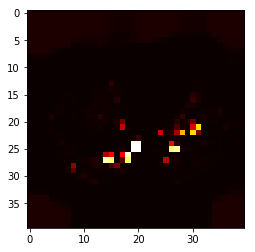

In [7]:
plt.imshow(prediction_slice, vmax=1, vmin=0, cmap='hot')

### Show the ground truth (doctor's annotations)

In [8]:
def load_mdf(mdf_file, nodule_info):
    itk_img = SimpleITK.ReadImage(mdf_file) 
    img_array = SimpleITK.GetArrayFromImage(itk_img) # z,y,x
    origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coordinates (mm)
    
    nodule_center_world = np.float32(nodule_info[1:4]) # x, y, z in world coordinates (mm)
    nodule_center_idx = np.rint((nodule_center_world - origin) / spacing).astype(np.int16)
    
    return img_array, nodule_center_idx

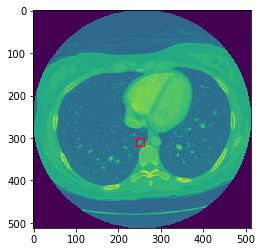

In [9]:
mhd_file_list = glob(luna_subset_path + "*.mhd")

nodule_info = mini_df_node.values[0]
seriesid = nodule_info[0]

mhd_file = next(f for f in mhd_file_list if seriesid in f)

img_array, nodule_center_idx = load_mdf(mhd_file, nodule_info)
nodule_x, nodule_y, nodule_z = nodule_center_idx

import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(img_array[nodule_z])
ax.add_patch(
    patches.Rectangle(
        (nodule_x - 10, nodule_y - 10),
        20,          # width
        20,          # height
        linewidth=1,edgecolor='r',facecolor='none'
    )
)

# Next Steps

Hard negative mining is one of the common techniques to reduce the false positives. Collect the false positives from the initial trained model, and restart the training using the false positive samples.

## Ideas for improvements

By looking at the learning curve, the model is overfitting to the training set. To overcome overfitting, we can consider, for example:
- Adding Dropout Layer
- Data Augmentation
- Decrease the model complexity
- etc.